In [1]:
import numpy as np
from scipy.io import netcdf as nc
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.basemap import Basemap, cm, shiftgrid, maskoceans
from matplotlib import colors
import numpy.ma as ma
from scipy.interpolate import griddata
import copy

In [2]:
nlon = 180
nlat = 90
grid_area = np.ones((nlat, nlon))*-9999.
earth_area =  5.096e14;
lat = np.arange(-89, 91, 2)
res = 2;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

In [33]:
############################################################
### diagnosis of spinup results
### updated with newly defined variable names
############################################################

## Some constants
nyr = 120

##  get and open the restart file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
filename_in = 'sshu.cori-haswell.E4f9ce69d2-Faaa10622.2022-03-20.elm.h0.chrv.1890_2009.nc'
# filename_in = 'extracted.nc'

fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years
patch_age_bins = fin.variables['fates_levage'][:]
cohort_size_bins = fin.variables['fates_levscls'][:]

## define the sizes of each dimension
ntim = len(time)
nagebins = len(patch_age_bins)
nsizebins = len(cohort_size_bins)

## read in variables
biomass = fin.variables['FATES_CANOPY_VEGC'][:]
area_age = fin.variables['FATES_CANOPYAREA_AP'][:]
landfrac = fin.variables['landfrac'][:]
# hrv_c = fin.variables['HARVEST_CARBON_FLUX'][:]
hrv_debt = fin.variables['HARVEST_DEBT'][:]
hrv_flux10c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD10C'][:]
hrv_flux100c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD100C'][:]
sec_frac = fin.variables['SECONDARY_FOREST_FRACTION'][:]

fin.close()

## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_area = fin_luinput.variables['AREA'][:]
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
lu_hrv_frac_vh1 = fin_luinput.variables['HARVEST_VH1'][:]
lu_hrv_frac_vh2 = fin_luinput.variables['HARVEST_VH2'][:]
lu_hrv_frac_sh1 = fin_luinput.variables['HARVEST_SH1'][:]
lu_hrv_frac_sh2 = fin_luinput.variables['HARVEST_SH2'][:]
lu_hrv_frac_sh3 = fin_luinput.variables['HARVEST_SH3'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
nat_area_frac = np.nansum(area_age, 1)
nat_area_frac[nat_area_frac>100] = 0.0
biomass_den = biomass
pft_4x5 = ncvar_pft
lat_4x5 = latnc
lon_4x5 = lonnc
lu_hrv_frac = lu_hrv_frac_vh1+lu_hrv_frac_vh2#+lu_hrv_frac_sh1+lu_hrv_frac_sh2+lu_hrv_frac_sh3
lu_hrv_c = lu_hrv_c_vh1+lu_hrv_c_vh2

KeyError: 'FATES_CANOPY_VEGC'

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


Text(0.5,1,'Validate spinup biomass')

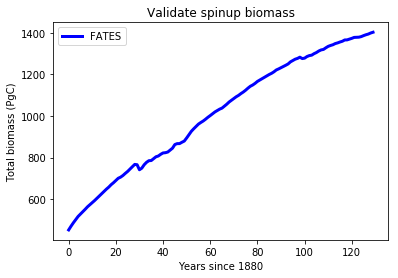

In [156]:
# Validate global total biomass C in Spinup
biomass_fates_day = copy.deepcopy(biomass_den)
biomass_fates_day[biomass_fates_day>100] = np.float('nan')
biomass_fates_yr = np.zeros([130, 46, 72])
for iyr in np.arange(0,nyr):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    biomass_fates_yr[iyr,:,:] = biomass_fates_day[id_end,:,:]*landfrac*area_4x5*nat_area_frac[id_end,:,:]*0.5*1e6
#     hrv_area_lu_yr[iyr,:,:] = lu_hrv_frac[151+iyr,:,:]*area_4x5*nat_area_frac[0,:,:]/1e6

# Mask ocean
biomass_fates_yr[biomass_fates_yr<0] = np.float('nan')

biomass_fates_yr_tot = np.nansum(np.nansum(biomass_fates_yr, 2), 1)/1e12
plt.plot(biomass_fates_yr_tot, 'b-', linewidth=3)
plt.xlabel('Years since 1880')
plt.ylabel('Total biomass (PgC)')
plt.legend(['FATES'])
plt.title('Validate spinup biomass')

In [158]:
np.nanmin(nat_area_frac)

0.0

In [50]:
############################################################
### Diagnosis of transient case
############################################################

## Some constants
nyr = 110

##  get and open the history file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
filename_in = 'sshu.cori-haswell.E4f9ce69d2-Faaa10622.2022-03-20.elm.h0.chrv.1890_2009.nc'
# filename_in = 'sshu.cori-haswell.E4f9ce69d2-Faaa10622.2022-03-20.elm.h0.1970-01.nc'
# filename_in = 'chrv.1900_1949.nc'
# filename_in = 'chrv.1950_2009.nc'

fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years
# patch_age_bins = fin.variables['fates_levage'][:]

## define the sizes of each dimension
ntim = len(time)
# nagebins = len(patch_age_bins)

## read in variables
sec_frac = fin.variables['FATES_SECONDARY_FOREST_FRACTION'][:]
biomass_ts = fin.variables['FATES_VEGC'][:]
biomass_age = fin.variables['FATES_VEGC_SZPF'][:]
area_age = fin.variables['FATES_PATCHAREA_AP'][:]
hrv_debt = fin.variables['HARVEST_DEBT'][:]
hrv_debt_sec = fin.variables['HARVEST_DEBT_SEC'][:]
hrv_flux10c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD10C'][:]
hrv_flux100c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD100C'][:]
sec_biomass = fin.variables['FATES_SECONDARY_FOREST_VEGC'][:]
# landfrac = fin.variables['landfrac'][:]

fin.close()

# fin = nc.netcdf_file('sshu.cori-haswell.E4f9ce69d2-Faaa10622.2022-03-20.elm.h0.chrv.1950_2009.nc')

# ## read in more variables
# sec_biomass = fin.variables['FATES_SECONDARY_FOREST_VEGC'][:]

# fin.close()

## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
lu_hrv_frac_vh1 = fin_luinput2.variables['HARVEST_VH1_FRAC'][:]
lu_hrv_frac_vh2 = fin_luinput2.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_frac_sh1 = fin_luinput2.variables['HARVEST_SH1_FRAC'][:]
lu_hrv_frac_sh2 = fin_luinput2.variables['HARVEST_SH2_FRAC'][:]
lu_hrv_frac_sh3 = fin_luinput2.variables['HARVEST_SH3_FRAC'][:]
fin_luinput2.close()

# Preprocessing
area_4x5 = ncvar_area
land_4x5 = ncvar_land
nat_area_frac = np.nansum(area_age, 1)
nat_area_frac[nat_area_frac>1] = np.float('nan')
# biomass_myr = np.nanmean(biomass_age, 0)
biomass_myr = biomass_age[0,:,:,:]
# biomass is in the dimension of size*pft
biomass_pft = np.zeros((12,46,72))
for i in np.arange(0,12):
    biomass_pft[i,:,:] = np.nansum(biomass_myr[(i-1)*13:i*13,:,:], 0)
pft_4x5 = np.nansum(biomass_pft, 0)
biomass_den = nat_area_frac[0,:,:]*pft_4x5
lat_4x5 = latnc
lon_4x5 = lonnc
lu_hrv_frac = lu_hrv_frac_vh1+lu_hrv_frac_sh1+lu_hrv_frac_sh2
lu_hrv_c = lu_hrv_c_vh1+lu_hrv_c_sh1+lu_hrv_c_sh2
lu_hrv_c_sec = lu_hrv_c_sh1+lu_hrv_c_sh2
fates_hrv_c = hrv_flux10c_elm+hrv_flux100c_elm
lu_hrv_nonf = lu_hrv_c_vh2+lu_hrv_c_sh3

In [5]:
# Comparison of the harvested area. It is not suitable for such a comparison 
# unless the biomass density from FATES model simulation matches the data LUH2 applied
hrv_area_fates_day = copy.deepcopy(sec_frac)
lu_hrv_frac_2 = copy.deepcopy(lu_hrv_frac)
biomass_day = copy.deepcopy(biomass_ts)

# Mask ocean
lu_hrv_frac_2[lu_hrv_frac_2<0] = np.float('nan')
hrv_area_fates_day[hrv_area_fates_day<0] = np.float('nan')
lu_hrv_frac_2[lu_hrv_frac_2>1] = np.float('nan')
hrv_area_fates_day[hrv_area_fates_day>1] = np.float('nan')

# Shall filter out enormously large gridcells since those patches locate 
# at places with sparse biomass
hrv_area_fates_day[hrv_area_fates_day>0.1] = 0.0

hrv_area_fates_yr = np.ones([60, 46, 72])*np.float('nan')
biomass_bef = np.ones([59, 46, 72])*np.float('nan')
delta_biomass = np.ones([59, 46, 72])*np.float('nan')
biomass_aft = np.ones([59, 46, 72])*np.float('nan')
hrv_area_lu_yr = np.ones([165, 46, 72])*np.float('nan')
for iyr in np.arange(0,nyr):
    id_beg = iyr*365
    id_end = (iyr+1)*365-1
    hrv_area_fates_yr[iyr,:,:] = (hrv_area_fates_day[id_end,:,:] - hrv_area_fates_day[id_beg,:,:])*ncvar_land#*area_4x5
    if(iyr < nyr-1):
        biomass_bef[iyr,:,:] = np.nanmean(biomass_day[id_beg:id_end,:,:], 0)
        biomass_aft[iyr,:,:] = np.nanmean(biomass_day[id_end+1:id_end+365,:,:], 0) 
    for i in np.arange(0,46):
        for j in np.arange(0,72):
            if(ncvar_land[i,j]>1.0):
                hrv_area_fates_yr[iyr,i,j] = np.float('nan')

delta_biomass = biomass_aft - biomass_bef

for iyr in np.arange(0,165):
    hrv_area_lu_yr[iyr,:,:] = lu_hrv_frac_2[iyr+1,:,:]*ncvar_land#*area_4x5
    for i in np.arange(0,46):
        for j in np.arange(0,72):
            if(ncvar_land[i,j]>1.0):
                hrv_area_lu_yr[iyr,i,j] = np.float('nan')
                        
hrv_area_fates_yr_tot = np.nansum(np.nansum(hrv_area_fates_yr*area_4x5, 2), 1)
hrv_area_lu_yr_tot = np.nansum(np.nansum(hrv_area_lu_yr*area_4x5*nat_area_frac[0,:,:], 2), 1)
plt.plot(hrv_area_fates_yr_tot, 'b-', linewidth=3)
plt.plot(hrv_area_lu_yr_tot[101:150], 'g--', linewidth=5)
plt.xlabel('Years since 1861')
plt.ylabel('Increment of Secondary Forest Fraction (per year, $km^2$)')
plt.legend(['FATES', 'LUC_TIMESERIES'])
plt.title('Validate reading LUC fraction')
plt.show()
# plt.savefig('validate_luc_frac_global.png')


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
C:\Users\sshu3\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


IndexError: index 1459 is out of bounds for axis 0 with size 1440

In [83]:
np.shape(sec_biomass)

(21912L, 46L, 72L)

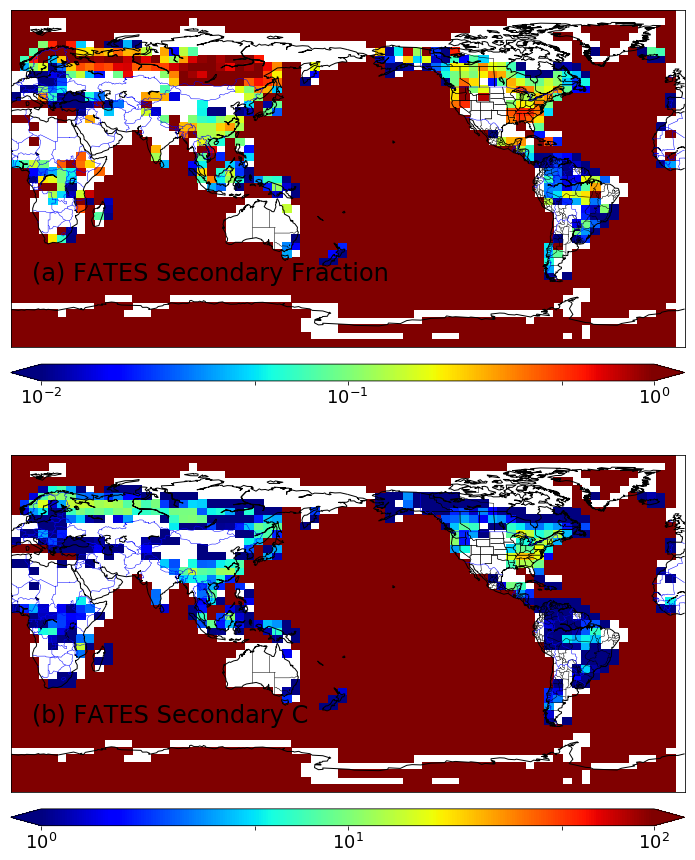

In [8]:
# Secondary forest area map (in fraction)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,sec_frac[400,:,:],
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-2),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.LogNorm(vmin=1e-2, vmax=1),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1e-2, 5e-2, 1e-1, 5e-1, 1],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES Secondary Fraction', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,sec_biomass[400,:,:],
#              norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.LogNorm(vmin=1, vmax=100),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[1, 5, 10, 50, 100],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Secondary C', fontsize=24)

plt.show()
# plt.savefig('FATES_SEC.jpg',dpi=300)

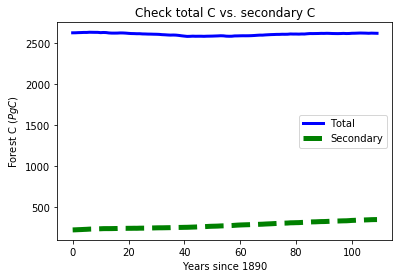

In [24]:
# Line plot secondary C vs. total C
biomass_day = copy.deepcopy(biomass_ts)
biomass_sec_day = copy.deepcopy(sec_biomass)

# Clear data with ocean mask
biomass_day[biomass_day>1e4] = np.float('nan')
biomass_sec_day[biomass_sec_day>1e4] = np.float('nan')

# New vars
biomass_yr = np.ones([nyr, 46, 72])*np.float('nan')
biomass_yr_sec = np.ones([nyr, 46, 72])*np.float('nan')
delta_biomass_sec = np.ones([nyr-1, 46, 72])*np.float('nan')

for iyr in np.arange(0,nyr):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    biomass_yr[iyr,:,:] = np.nanmean(biomass_day[id_beg:id_end,:,:])*area_4x5*nat_area_frac[0,:,:]*1e6
    biomass_yr_sec[iyr,:,:] = np.nanmean(biomass_sec_day[id_beg:id_end,:,:])*area_4x5*nat_area_frac[0,:,:]*1e6
    if(iyr > 0):
        delta_biomass_sec[iyr-1,:,:] = biomass_yr_sec[iyr,:,:] - biomass_yr_sec[iyr-1,:,:]

biomass_yr_tot = np.nansum(np.nansum(biomass_yr, 2), 1)/1e12
biomass_sec_yr_tot = np.nansum(np.nansum(biomass_yr_sec, 2), 1)/1e12
plt.plot(biomass_yr_tot, 'b-', linewidth=3)
plt.plot(biomass_sec_yr_tot, 'g--', linewidth=5)
plt.xlabel('Years since 1890')
plt.ylabel('Forest C ($PgC$)')
plt.legend(['Total', 'Secondary'])
# plt.ylim([0, 500])
plt.title('Check total C vs. secondary C')
plt.show()
# plt.savefig('validate_luc_frac_global.png')



C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


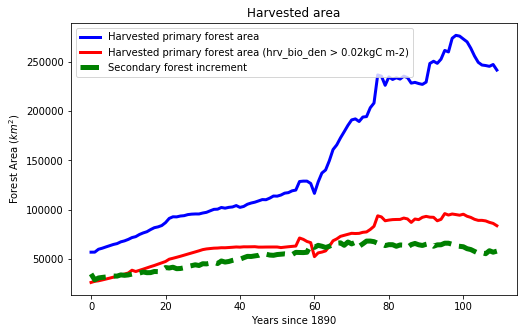

In [86]:
# Line plot secondary forest area vs. total forest area
# Line plot secondary C vs. total C
area_day = copy.deepcopy(lu_hrv_frac[40:160,:,:])
area_sec_day = copy.deepcopy(sec_frac)

# Clear data with ocean mask
area_day[area_day>1e4] = np.float('nan')
area_sec_day[area_sec_day>1e4] = np.float('nan')

# New vars
area_yr = np.ones([nyr, 46, 72])*np.float('nan')
filtered_area_yr = np.ones([nyr, 46, 72])*np.float('nan')
area_yr_sec = np.ones([nyr, 46, 72])*np.float('nan')
delta_area_sec = np.ones([nyr-1, 46, 72])*np.float('nan')

for iyr in np.arange(0,nyr):
    tt = copy.deepcopy(area_day[iyr,:,:])
    tt[biomass_den<20] = np.float('nan')
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    area_yr[iyr,:,:] = area_day[iyr,:,:]*area_4x5*nat_area_frac[iyr,:,:]
    filtered_area_yr[iyr,:,:] = tt*area_4x5*nat_area_frac[iyr,:,:]
    area_yr_sec[iyr,:,:] = (area_sec_day[id_end,:,:]-area_sec_day[id_beg,:,:])*area_4x5*nat_area_frac[iyr,:,:]
    if(iyr > 0):
        delta_area_sec[iyr-1,:,:] = area_yr_sec[iyr,:,:] - area_yr_sec[iyr-1,:,:]

area_yr_tot = np.nansum(np.nansum(area_yr, 2), 1)
filtered_area_yr_tot = np.nansum(np.nansum(filtered_area_yr, 2), 1)
area_sec_yr_tot = np.nansum(np.nansum(area_yr_sec, 2), 1)

fig = plt.figure(figsize=(8,5))
plt.plot(area_yr_tot, 'b-', linewidth=3)
plt.plot(filtered_area_yr_tot, 'r-', linewidth=3)
plt.plot(area_sec_yr_tot, 'g--', linewidth=5)
plt.xlabel('Years since 1890')
plt.ylabel('Forest Area ($km^2$)')
plt.legend(['Harvested primary forest area', 'Harvested primary forest area (hrv_bio_den > 0.02kgC m-2)', \
            'Secondary forest increment'], loc= 'upper left')
# plt.ylim([0, 500])
plt.title('Harvested area')
#plt.show()
plt.savefig('validate_luc_frac_global.png')


In [68]:
np.shape(area_day)

(120L, 46L, 72L)

In [26]:
# Line plot secondary forest area vs. primary forest harvested
# Line plot secondary C vs. total C
area_day = copy.deepcopy(nat_area_frac)
area_sec_day = copy.deepcopy(sec_frac)

# Clear data with ocean mask
area_day[area_day>1e4] = np.float('nan')
area_sec_day[area_sec_day>1e4] = np.float('nan')

# New vars
area_yr = np.ones([nyr, 46, 72])*np.float('nan')
area_yr_sec = np.ones([nyr, 46, 72])*np.float('nan')
delta_area_sec = np.ones([nyr-1, 46, 72])*np.float('nan')

for iyr in np.arange(0,nyr):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    area_yr[iyr,:,:] = np.nanmean(area_day[id_beg:id_end,:,:])*area_4x5
    area_yr_sec[iyr,:,:] = np.nanmean(area_sec_day[id_beg:id_end,:,:])*area_4x5
    if(iyr > 0):
        delta_area_sec[iyr-1,:,:] = area_yr_sec[iyr,:,:] - area_yr_sec[iyr-1,:,:]

area_yr_tot = np.nansum(np.nansum(area_yr, 2), 1)
area_sec_yr_tot = np.nansum(np.nansum(area_yr_sec, 2), 1)
plt.plot(area_yr_tot, 'b-', linewidth=3)
plt.plot(area_sec_yr_tot, 'g--', linewidth=5)
plt.xlabel('Years since 1890')
plt.ylabel('Forest Area ($km^2$)')
plt.legend(['Total', 'Secondary'])
# plt.ylim([0, 500])
plt.title('Check total area vs. secondary area')
plt.show()

(1440L, 46L, 72L)

In [54]:
np.shape(lu_hrv_frac)

(166L, 46L, 72L)

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


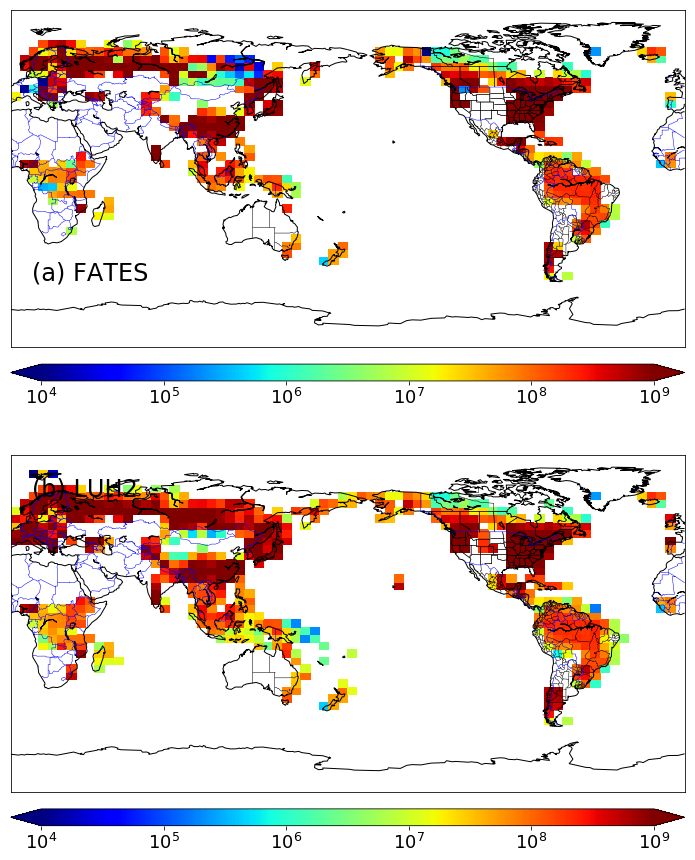

In [42]:
# Mask ocean
fates_hrv_c[fates_hrv_c>1e4] = np.float('nan')

# Secondary forest area map (in KgC)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,fates_hrv_c[120,:,:]*1e-3*area_4x5*1e6*3600*24*365,
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,lu_hrv_c[49,:,:],
#              norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.43, '(b) LUH2', fontsize=24)

#plt.show()
plt.savefig('PRIM_HARV.jpg',dpi=300)

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


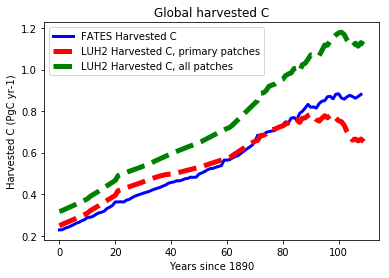

In [53]:
# Check the total harvested C.
## Validate harvested C (gC m-2 yr-1). 
lu_hrv_c_tot = copy.deepcopy(lu_hrv_c)
lu_hrv_c_prim = copy.deepcopy(lu_hrv_c-lu_hrv_c_sec)
fates_hrv_c_tot = np.zeros((nyr, 46, 72))

# Apply Mask 
# No cohorts
fates_hrv_c[fates_hrv_c>1] = np.float('nan')

for iyr in np.arange(0,nyr-1):
    # Middle of year
    id_beg = iyr*12+1
    # gC m-2 s-1 -> kg C
    fates_hrv_c_tot[iyr, :, :] = fates_hrv_c[id_beg,:,:]*1e-3*area_4x5*1e6*3600*24*365
    
hrv_c_luh2_yr_tot = np.nansum(np.nansum(lu_hrv_c_tot, 2), 1)/1e12
hrv_c_luh2_yr_prim = np.nansum(np.nansum(lu_hrv_c_prim, 2), 1)/1e12
hrv_c_fates_yr_tot = np.nansum(np.nansum(fates_hrv_c_tot, 2), 1)/1e12

plt.plot(hrv_c_fates_yr_tot[0:109], 'b-', linewidth=3)
plt.plot(hrv_c_luh2_yr_prim[40:150], 'r--', linewidth=5)
plt.plot(hrv_c_luh2_yr_tot[40:150], 'g--', linewidth=5)
plt.xlabel('Years since 1890')
plt.ylabel('Harvested C (PgC yr-1)')
plt.ylabel('Harvested C (PgC yr-1)')
# plt.ylim([0, 0.8])
plt.legend(['FATES Harvested C', 'LUH2 Harvested C, primary patches', 'LUH2 Harvested C, all patches'])
plt.title('Global harvested C')
#plt.show()
plt.savefig('validate_hrv_c_global.png')


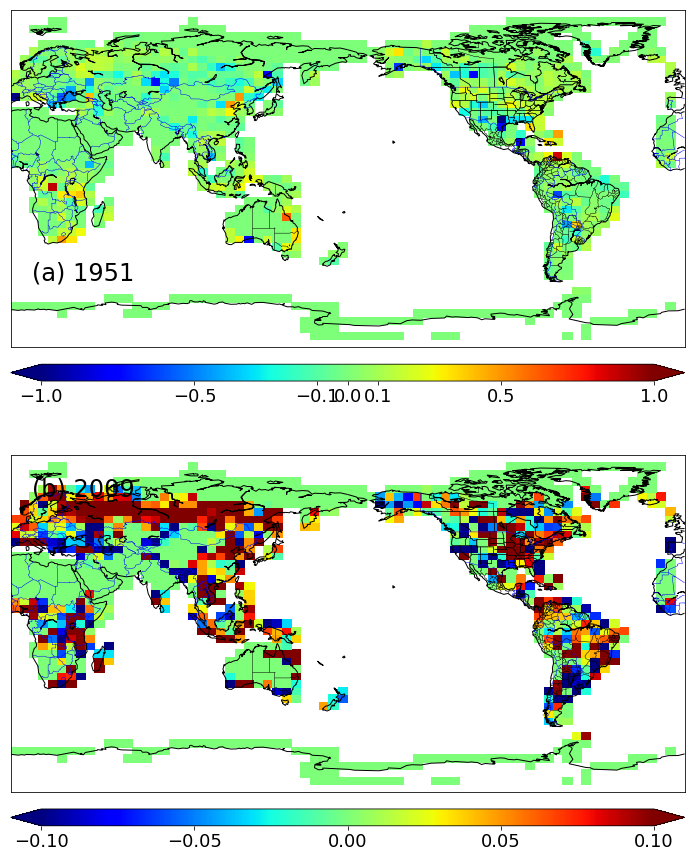

In [126]:
## Check VegC change for every year
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,delta_biomass[0,:,:],
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=-1, vmax=1),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[-1, -0.5, -0.1, 0, 0.1, 0.50, 1],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) 1951', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,delta_biomass[58,:,:],
#              norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=-0.1, vmax=0.1),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[-0.1, -0.05, 0, 0.05, 0.1],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.43, '(b) 2009', fontsize=24)

#plt.show()
plt.savefig('DvegC.jpg',dpi=300)


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


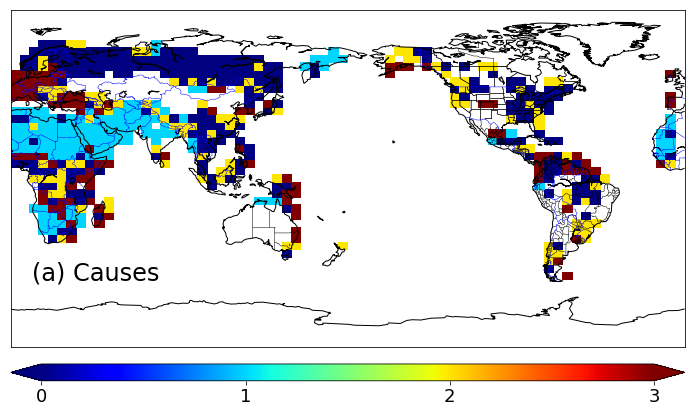

In [165]:
## Map to show what type of issue each gridcell has when logging is introduced.
# Check the total harvested C.
## Validate harvested C (gC m-2 yr-1). 
# reason_map = np.ones((46, 72))*np.float('nan')
biomass_init = biomass_ts[0,:,:]
ch_biomass = delta_biomass[58,:,:]*sec_frac[21911,:,:]*area_4x5*1e6
ch_hrv_debt_sec = hrv_debt_sec[21911,:,:] - hrv_debt_sec[21546,:,:]
hrv_req = lu_hrv_c_sec[160,:,:]
mature_area = area_age[59, 6, :, :]
secbiomass_minus_hrv = sec_biomass[21911,:,:]*area_4x5*1e6 - lu_hrv_c_sh1[160,:,:] - lu_hrv_c_sh3[160,:,:]
ch_minus_req = ch_biomass*area_4x5*1e6 - ch_hrv_debt_sec
debt_mask = copy.deepcopy(hrv_debt_sec[21911,:,:])
debt_mask[debt_mask>1e15] = -9999.
sec_frac_mask = copy.deepcopy(sec_frac[21911,:,:])

# Apply Mask
# 0. Secondary forest did not reach maturity
reason_map = np.zeros((46, 72))

# 2. Low growth rate 
# Change of secondary biomass lower than the harvest rate
reason_map[ch_minus_req<0] = 2
# reason_map[secbiomass_minus_hrv>0] = 0

# 3. Too tiny secondary forest area (<1% of gridcell)
reason_map[sec_frac_mask<0.01] = 3

# 1. No cohorts survived
# Zero biomass grids with secondary forest harvest debt
reason_map[biomass_init==0] = 1

# Mask out area with no secondary forest harvest debt
reason_map[debt_mask<=0] = np.float('nan')


lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,reason_map,
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=0, vmax=3),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[0, 1, 2, 3],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) Causes', fontsize=24)

# for iyr in np.arange(0,nyr-1):
#     # Middle of year
#     id_beg = iyr*12+1
#     # gC m-2 s-1 -> kg C
#     fates_hrv_c_tot[iyr, :, :] = fates_hrv_c[id_beg,:,:]*1e-3*area_4x5*1e6*3600*24*365
    
# hrv_c_luh2_yr_tot = np.nansum(np.nansum(lu_hrv_c_tot, 2), 1)/1e12
# hrv_c_fates_yr_tot = np.nansum(np.nansum(fates_hrv_c_tot, 2), 1)/1e12

# plt.plot(hrv_c_fates_yr_tot, 'b-', linewidth=3)
# plt.plot(hrv_c_luh2_yr_tot[0:40], 'g--', linewidth=5)
# plt.xlabel('Years since 1850')
# plt.ylabel('Harvested C (PgC yr-1)')
# plt.ylabel('Harvested C (PgC yr-1)')
# # plt.ylim([0, 0.8])
# plt.legend(['FATES Harvested C', 'LUH2 Harvested C'])
# plt.title('Validate harvested C')
# plt.show()
plt.savefig('causes.png')


In [35]:
np.shape(lu_hrv_nonf)

(166L, 46L, 72L)

In [133]:
21912-365

21547

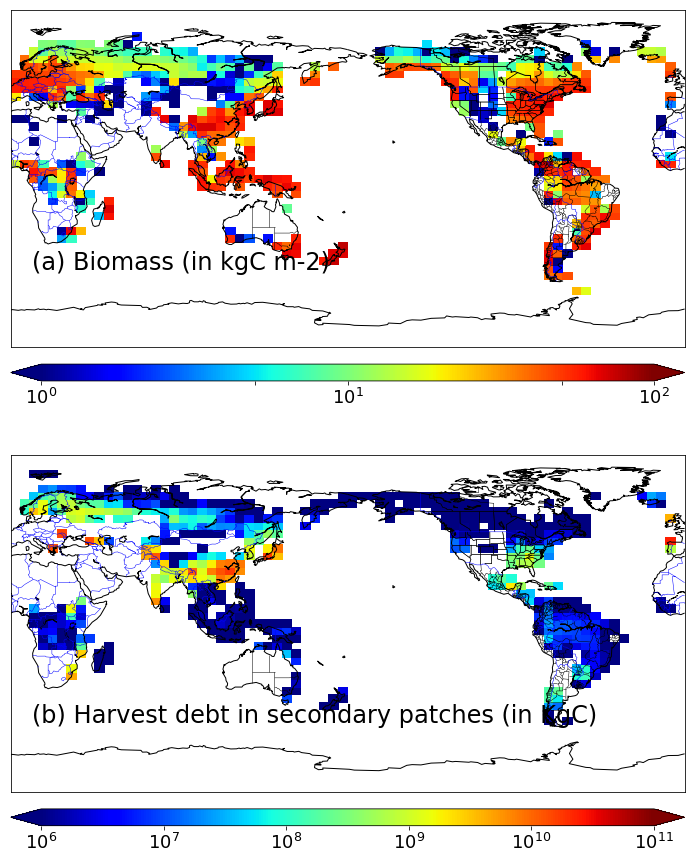

In [43]:
flag = lu_hrv_nonf[50,:,:]
hrv_debt_sec_cp = copy.deepcopy(hrv_debt_sec[120,:,:])
hrv_debt_sec_cp[hrv_debt_sec_cp>1e15] = np.float('nan')
hrv_debt_sec_cp[flag>0] = np.float('nan')

# Biomass map
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,biomass_den[:,:],
              norm=colors.LogNorm(vmin=1, vmax=1e2),cmap=plt.cm.jet) # use log color scale,
cbar = map.colorbar(cs1,ticks=[1, 5, 10, 50, 100],location='bottom',pad="5%",extend='both')

# cs1 = map.pcolormesh(x,y,hrv_debt_sec[100,:,:],
#               norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.cm.jet) # use log color scale,
# cbar = map.colorbar(cs1,ticks=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9],location='bottom',pad="5%",extend='both')

# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.64, '(a) Biomass (in kgC m-2)', fontsize=24)

# Harvest debt map
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,hrv_debt_sec_cp,
              norm=colors.LogNorm(vmin=1e6, vmax=1e11),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[1e6, 1e7, 1e8, 1e9, 1e10, 1e11],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) Harvest debt in secondary patches (in KgC)', fontsize=24)

#plt.show()
plt.savefig('FATES_biomass_hrvdebt_global_map.png')

In [38]:
np.shape(flag)

(46L, 72L)

IndexError: too many indices for array

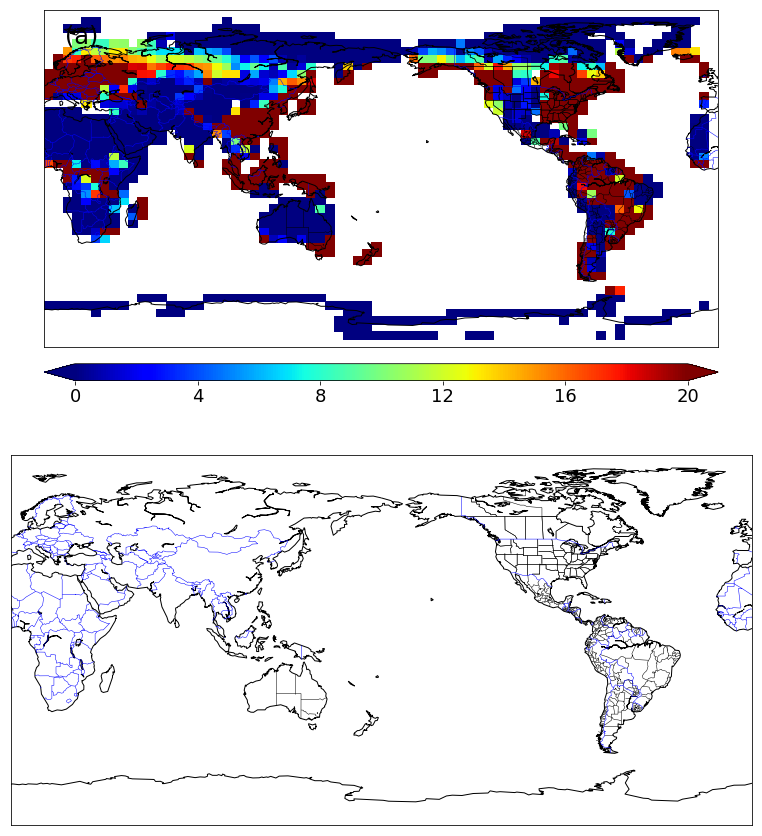

In [44]:
# Biomass plot
# Secondary forest area map
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,biomass_den[:,:],
              norm=colors.Normalize(vmin=0, vmax=20),cmap=plt.cm.jet) # use log color scale,

cbar = map.colorbar(cs1,ticks=[0, 4, 8, 12, 16, 20],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.85, '(a)', fontsize=24)

## Biomass den from LUH2?
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,biomass_den[3650,:,:]-biomass_den[0,:,:],
              norm=colors.Normalize(vmin=-1, vmax=1),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.43, '(b)', fontsize=24)

plt.show()
# plt.savefig('SEC_FRAC.jpg',dpi=300)



(3651L, 46L, 72L)

In [ ]:
############################################################
### WARNING: THIS CALCULATION CONSUME MUCH TIME
### DON'T RUN IT UNLESS YOU REALLY NEED RESULTS
### Check the output biomass data from FATES
### Dominant PFTs, number of PFTs from the surface data
############################################################
filename_in = 'extracted_chrv_1850s.nc'

fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years
patch_age_bins = fin.variables['fates_levage'][:]

## define the sizes of each dimension
ntim = len(time)
nagebins = len(patch_age_bins)

## read in variables
sec_frac = fin.variables['FATES_SECONDARY_FOREST_FRACTION'][:]
biomass_age = fin.variables['FATES_VEGC_SZPF'][:]
area_age = fin.variables['FATES_PATCHAREA_AP'][:]
hrv_debt = fin.variables['HARVEST_DEBT'][:]
hrv_debt_sec = fin.variables['HARVEST_DEBT_SEC'][:]
hrv_flux10c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD10C'][:]
hrv_flux100c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD100C'][:]
# landfrac = fin.variables['landfrac'][:]

fin.close()

### Any biomass value higher than 0.01 shall be accounted
biomass_myr = np.nanmean(biomass_age, 0)
# biomass is in the dimension of size*pft
biomass_pft = np.zeros((12,46,72))
for i in np.arange(0,12):
    biomass_pft[i,:,:] = np.nansum(biomass_myr[(i-1)*13:i*13,:,:], 0)

numpft_fates = np.zeros((46,72))
dompft_fates = np.zeros((46,72))
## Calculate numbers of PFTs
for i in np.arange(0,72):
    for j in np.arange(0,46):
        dominant_k = 1
        for k in np.arange(1,12):
            if(biomass_pft[k,j,i] > 0.0):
                numpft_fates[j,i] = numpft_fates[j,i] + 1
            if(biomass_pft[k,j,i]>biomass_pft[dominant_k,j,i]):
                dominant_k = k
                dompft_fates[j,i] = k

### Plot to show number of PFTs and the dominant PFT
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,numpft_fates[:,:],
              norm=colors.Normalize(vmin=0, vmax=5),cmap=plt.cm.jet) # use log color scale,

cbar = map.colorbar(cs1,ticks=[0, 1, 2, 3, 4, 5],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.64, '(a) Number of PFTs - FATES', fontsize=24, color='White')

# Harvest debt map
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,dompft_fates[:,:],
              norm=colors.Normalize(vmin=0, vmax=6),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[0, 1, 2, 3, 4, 5, 6],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) Dominant PFT - FATES', fontsize=24, color='White')

# plt.show()
plt.savefig('fates_fixed_biogeog_map_global_4x5.png')